## Counting mentions of Wikipedia articles in Reddit submission titles

### Prerequisites

1. Download a dump of Wikipedia's articles, named `enwiki-{date_string}-pages-articles-multistream.xml.bz2`
2. Download the `enwiki-{date_string}-pages-articles-multistream-index.txt.bz2` file
3. Move those files into the same folder, removing the `enwiki-{date_string}` prefix
4. Process the `xml.bz2` file into a Parquet file using `wikiplain.load_bz2`
5. Run `PageRank.ipynb`

In [1]:
import asyncio
import glob
import gzip
import io
import itertools
import json
import math
import operator
import os
import pickle
import random
import re
import shutil
import socket
import struct
import subprocess
import sys
import tarfile
import time
from collections import ChainMap, defaultdict, deque
from concurrent.futures import ThreadPoolExecutor
from contextlib import asynccontextmanager, contextmanager
from dataclasses import dataclass
from datetime import datetime
from enum import Enum, auto
from functools import lru_cache, partial
from urllib.parse import urlencode, urlsplit, quote as urlquote, unquote as urlunquote
from xml.sax.saxutils import unescape as xml_unescape
from typing import Any, Awaitable, Callable, Literal, TypeVar

import cbor2
import httpx
import ijson
import matplotlib.pyplot as plt
import mmh3
import numpy as np
import pandas as pd
import pypocketmap as pkm
import pyarrow
import pyarrow.parquet as pq
import polars as pl
import redis
import seaborn as sns
import sqlalchemy as sa
import scipy.sparse
import toolz
from dotenv import load_dotenv
from ipywidgets import interact
from spacy.lang.en import English
from sqlalchemy import create_engine
from sqlalchemy.sql import column as sqlcolumn, select, text as sqltext
from tqdm.auto import tqdm
from zstandard import ZstdDecompressor, ZstdDecompressionReader
from arsenal.datastructures.unionfind import UnionFind
from arsenal.datastructures.heap import MinMaxHeap

import wikiplain
from special_cases import SECOND_LEVEL_DOMAINS
from nbhelpers.polars import pager, searcher
from umbc_web.process_possf2 import PENN_TAGS, PENN_TAGS_BY_ID

In [2]:
load_dotenv()

True

In [3]:
pl.Config.set_fmt_str_lengths(160)

polars.config.Config

In [4]:
class RedditRankFiles:
    def __init__(self, date_string):
        self.date_string = date_string
        self.enwiki_dir = f"{os.environ['ENWIKI_DIR']}/{date_string}"
        self.parquet_dir = os.environ.get('ENWIKI_PARQUET_DIR', self.enwiki_dir)
        self.reddit_dir = f"{os.environ['REDDIT_DIR']}"
        try:
            os.mkdir(f"{self.enwiki_dir}/pagerank")
        except FileExistsError:
            pass
    
    @property
    def enwiki_parquet_filename(self):
        return f"{self.parquet_dir}/enwiki_{self.date_string}.parquet"
    
    @property
    def pagerank_parquet_filename(self):
        return f"{self.parquet_dir}/enwiki_{self.date_string}_pagerank.parquet"
    
    @property
    def redditrank_parquet_filename(self):
        return f"{self.parquet_dir}/enwiki_{self.date_string}_redditrank.parquet"
    
    @property
    def enwiki_tokenized_arrow_filename(self):
        return f"{self.parquet_dir}/enwiki_tokenized.arrow"
    
    @property
    def enwiki_tokenized_database_uri(self):
        return f"sqlite:///{self.parquet_dir}/enwiki_tokenized_{self.date_string}.sqlite"

    @property
    def nub_filename(self):
        return f"{self.enwiki_dir}/pagerank/nub.bin"
    
    @property
    def id_map_filename(self):
        return f"{self.enwiki_dir}/pagerank/id_map.bin"
    
    @property
    def id_map2_filename(self):
        return f"{self.enwiki_dir}/pagerank/id_map2.bin"
    
    @property
    def dense_id_arr_filename(self):
        return f"{self.enwiki_dir}/pagerank/dense_id_arr.npy"
    
    @property
    def edge_filename_pattern(self):
        return f"{self.enwiki_dir}/pagerank/edges_*.npz"
    
    def edge_filenames(self, num_partitions):
        return [
            f"{self.enwiki_dir}/pagerank/edges_{i}.npz"
            for i in range(num_partitions)
        ]
    
    @property
    def hatedge_filename_pattern(self):
        return f"{self.enwiki_dir}/pagerank/hatedges_*.npy"
    
    def hatedge_filenames(self, num_partitions):
        return [
            f"{self.enwiki_dir}/pagerank/hatedges_{i}.npy"
            for i in range(num_partitions)
        ]
    
    @property
    def hatcheck_arr_filename(self):
        return f"{self.enwiki_dir}/pagerank/hatcheck_arr.npy"

    @property
    def in_degree_filename(self):
        return f"{self.enwiki_dir}/pagerank/in_degree.npy"
    
    @property
    def out_degree_filename(self):
        return f"{self.enwiki_dir}/pagerank/out_degree.npy"
    
    @property
    def disambig_arr_filename(self):
        return f"{self.enwiki_dir}/pagerank/disambig_arr.npy"
    
    @property
    def top_cite_domains_filename(self):
        return f"{self.enwiki_dir}/pagerank/top_cite_domains.bin"

    @property
    def reddit_relevance_filename_pattern(self):
        return f"{self.enwiki_dir}/redditrank/RS_*.npy"
    
    def adjacency_filename(self, partition):
        return f"{self.enwiki_dir}/pagerank/adjacency_{partition}.npz"
    
    def adjacency_filenames(self, num_partitions):
        return [self.adjacency_filename(i) for i in range(num_partitions)]

    @property
    def category_id_map_filename(self):
        return f"{self.enwiki_dir}/categories/category_id_map.bin"

    @property
    def encategory_graph_database_uri(self):
        return f"sqlite:///{self.parquet_dir}/enwiki_category_graph_{self.date_string}.sqlite"
    
    @property
    def template_id_maps_filename(self):
        return f"{self.enwiki_dir}/pagerank/template_id_maps.pkl"

In [5]:
date_string = os.environ.get("DS", "20250201")
files = RedditRankFiles(date_string)

### Re-use outputs computed by PageRank.ipynb

1. Pages with the same title
2. `id_map` from non-redirecting article titles to node number, and `id_map2` from redirecting article titles to node number

In [6]:
def iterdecode(f):
    decoder = cbor2.CBORDecoder(f)
    while True:
        try:
            yield decoder.decode()
        except EOFError:
            return

In [7]:
# with open(files.nub_

In [8]:
with open(files.id_map_filename, "rb") as fp:
    id_map = pkm.create(str, int)
    for k, v in iterdecode(fp):
        id_map[k] = v
with open(files.id_map2_filename, "rb") as fp:
    id_map2 = pkm.create(str, int)
    for k, v in iterdecode(fp):
        id_map2[k] = v
# with open(files.dense_id_arr_filename, "rb") as fp:
#     dense_id_arr = np.load(fp)

In [9]:
N = len(id_map)
# ids_concat = pyarrow.array(itertools.chain(id_map.keys(), id_map2.keys()), size=len(id_map) + len(id_map2))

In [10]:
# node_ids_concat = pyarrow.array(itertools.chain(id_map.values(), id_map2.values()), size=len(id_map) + len(id_map2), type=pyarrow.uint32())

In [11]:
LOG_PARTITION_SIZE = 16
PARTITION_SIZE = 1 << LOG_PARTITION_SIZE
NUM_PARTITIONS = math.ceil(N / PARTITION_SIZE)

In [12]:
PR = pl.read_parquet(files.pagerank_parquet_filename)
PR_value = PR["value"].to_numpy()

### Wikipedia article stats

1. Create `disambig_arr`, a simple boolean array recording whether each article is a disambiguation or set-index page.
2. Create `top_cite_domains`, the 1024 most commonly cited websites across all articles.

In [13]:
class Vec:
    def __init__(self, dtype):
        self.array = np.ndarray((1024,), dtype=dtype)
        self.length = 0
    
    @property
    def capacity(self):
        return self.array.shape[0]

    def append(self, v):
        idx = self.length
        if idx >= self.capacity:
            addsz = max(2, self.capacity)
            self.array = np.hstack((self.array, np.zeros((addsz,), dtype=self.array.dtype)))
        self.array[idx] = v
        self.length += 1

In [14]:
def chunk(iterable, size):
    """Split an iterable into list chunks of size `n`.
    
    The last chunk can be fewer than `n` elements long, but it won't be empty.
    """
    iterator = iter(iterable)
    while True:
        chunk = list(itertools.islice(iterator, size))
        if chunk:
            yield chunk
        else:
            return

def lazy_chunk(iterable, n):
    """Split an iterable into iterable chunks of size `n`.
    
    The last chunk can be fewer than `n` elements long, but it won't be empty.
    """
    iterator = iter(iterable)
    while True:
        try:
            first = next(iterator)
        except StopIteration:
            return
        yield itertools.chain([first], itertools.islice(iterator, n - 1))

In [15]:
with open(files.disambig_arr_filename, "rb") as fp:
    disambig_arr = np.load(fp)

In [18]:
with open(files.top_cite_domains_filename, "rb") as fp:
    top_cite_domains = cbor2.load(fp)

In [19]:
pager(pl.DataFrame(top_cite_domains, schema=['domain', 'count']), 16)

interactive(children=(Dropdown(description='page', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

<function nbhelpers.polars.pager.<locals>.<lambda>(page)>

In [20]:
searcher(pl.DataFrame(top_cite_domains, schema=['domain', 'count'])
          .with_columns(pl.Series("rank", range(len(top_cite_domains)))),
         ["domain"],
         16)

interactive(children=(Text(value='', description='q'), Output()), _dom_classes=('widget-interact',))

<function nbhelpers.polars.searcher.<locals>.searcher_run(q)>

In [21]:
excluded_domains = {"imgur.com", "twitter.com", "youtube.com", "soundcloud.com",
                    "instagram.com", "amazon.com", "github.com", "vimeo.com",
                    "google.com"
                   }
top_cite_domain_set = {domain for domain, _ in top_cite_domains} - excluded_domains

In [22]:
ORDER_TAG_BITS = 3
NUM_ORDER_TAGS = 1 << ORDER_TAG_BITS
DEST_ID_BITS = 31 - ORDER_TAG_BITS
DEST_ID_MASK = (1 << DEST_ID_BITS) - 1
@lru_cache(maxsize=1)
def load_edges(partition):
    with np.load(files.edge_filenames(NUM_PARTITIONS)[partition]) as npz:
        return list(npz.values())

In [23]:
with open(files.hatcheck_arr_filename, "rb") as fp:
    hatcheck_arr = np.load(fp)

In [24]:
@lru_cache(maxsize=1)
def load_hatedges(partition):
    return np.load(files.hatedge_filenames(NUM_PARTITIONS)[partition])

In [25]:
test_node_id = id_map["Apple"]
hatedges = load_hatedges(test_node_id >> LOG_PARTITION_SIZE)
hatedges[hatedges[:, 0] == test_node_id]

array([[  2302503, 268436216]], dtype=int32)

In [26]:
hatcheck_arr[test_node_id]

True

In [27]:
np.mean(hatcheck_arr)

0.03953997482711186

In [28]:
PR_log_median = np.log2(np.median(PR_value))
PR_log_min = np.log2(PR_value.min())
np.histogram(np.log2(PR_value))

(array([ 720949, 3952346, 1527775,  453263,  134884,   38301,    9575,
           1747,     240,      24]),
 array([-27.62334683, -25.84432445, -24.06530207, -22.28627969,
        -20.50725731, -18.72823493, -16.94921255, -15.17019017,
        -13.39116779, -11.61214541,  -9.83312303]))

In [29]:
np.quantile(np.log2(PR_value), np.linspace(0, 1, 21))

array([-27.62334683, -26.14214513, -25.87458402, -25.67740969,
       -25.52170179, -25.38920619, -25.26136846, -25.13085597,
       -24.99746819, -24.86020111, -24.71722233, -24.56519087,
       -24.39790961, -24.20857527, -23.98734102, -23.72366679,
       -23.39934503, -22.97848152, -22.38788695, -21.38296688,
        -9.83312303])

In [30]:
PR_log_mean = np.log2(PR_value.mean())
PR_log_mean

-22.705375897442785

### Create SQLite database for token-string to Wikipedia article map

- Occurrence of a normal article title: weight = 2
- Occurrence of a title redirecting to a normal article: weight = 2
  - In either case, up to 0.66 is redistributed to hatnotes linking to other articles if there are any
    - weights = `(log2(PR_value) - PR_log_min)/2/(PR_log_mean - PR_log_min)`, normalized to sum 0.8 if over
- Occurrence of a disambiguation article title: weight = 2 distributed to all articles linked from that page
  - &lt;5 links: weights = `2*normalize(PR_value)`
  - &ge;5 links: weights = `2*normalize(PR_value)` interpolated with `2*normalize(PR_value * [5,4,2,1,0,0,0,...])`, alpha = `min(0.75, log2(N-4)/8)` (halfway at 20 links, saturates at 60)
    - This is because disambiguation pages for popular terms will usually have a 'most commonly referred to' section at the top, and they're more likely to have lots of links.

#### Edge format (copied from PageRank)

- `edges_{n}.pkl` stores the outgoing links from `PARITION_SIZE*n ..< PARTITION_SIZE*(n+1)`
- These are stored in a list where element `i` contains the links out to `PARITION_SIZE*i ..< PARTITION_SIZE*(i+1)`

In [31]:
nlp = English()

In [37]:
max_span_map = {}
def tokens_to_term(tokens):
    parts = [token.norm_ for token in tokens if not (token.is_left_punct or token.is_right_punct)]
    if len(parts) > 0 and len(parts) > max_span_map.get(parts[0], -1):
        max_span_map[parts[0]] = len(parts)
    return " ".join(parts)

iterator = tqdm(itertools.chain(id_map.keys(), id_map2.keys()), total=len(id_map) + len(id_map2))
terms_concat = pyarrow.array(
    map(tokens_to_term, nlp.tokenizer.pipe(iterator)),
    size=len(id_map) + len(id_map2)
)

  0%|          | 0/17826633 [00:00<?, ?it/s]

In [38]:
term_table = pyarrow.table({
    "term": terms_concat,
    "node_id": pyarrow.array(
        # todo construct at same time ^^
        itertools.chain(id_map.values(), id_map2.values()),
        size=len(id_map) + len(id_map2)
    )
})

In [39]:
term_table = term_table.sort_by("term")

In [40]:
def gen_weights():
    iterator = zip(tqdm(term_table.columns[0]), term_table.columns[1])
    for _, group in itertools.groupby(iterator, lambda e: e[0]):
        node_ids = [n.as_py() for _, n in group]
        _, unique_indices = np.unique(node_ids, return_index=True)
        weights = np.zeros(len(node_ids), dtype=np.float64)
        weights[unique_indices] = PR_value[node_ids][unique_indices]
        weights /= weights.sum()
        yield from weights

weight_arr = pyarrow.array(gen_weights(), size=len(terms_concat))

  0%|          | 0/17826633 [00:00<?, ?it/s]

In [41]:
%reset -f out

Flushing output cache (12 entries)


In [42]:
term_table = term_table.add_column(2, "weight", weight_arr)

In [44]:
term_table = term_table.sort_by("node_id")

In [45]:
pyarrow.parquet.write_table(term_table, files.enwiki_tokenized_arrow_filename)

In [33]:
# term_table = pyarrow.parquet.read_table(files.enwiki_tokenized_arrow_filename)

In [46]:
term_table.filter(pyarrow.compute.starts_with(term_table.columns[0], "apple"))

pyarrow.Table
term: string
node_id: int64
weight: double
----
term: [["apple i","apple i character set","apple i computer","apple-1","applet",...,"apple music 's 100 best albums","apple music 100 best albums","apple bread","apple intelligence","apple passwords"]]
node_id: [[153,153,153,153,563,...,6821648,6821648,6830331,6833385,6834031]]
weight: [[1,1,1,1,1,...,1,1,1,1,1]]

In [47]:
engine = create_engine(files.enwiki_tokenized_database_uri)

In [48]:
redis_engine = redis.Redis("127.0.0.1")

In [68]:
def gen_assigned_weights():
    table = term_table  #.filter(pyarrow.compute.starts_with(term_table.columns[0], "apple"))
    iterator = zip(tqdm(table.columns[0]), table.columns[1], table.columns[2])
    early_multipliers = np.array([1, 2, 4, 5])
    for term_scalar, node_id_scalar, w_scalar in iterator:
        term = term_scalar.as_py()
        if term == "":
            continue
        w = w_scalar.as_py()
        if w == 0:
            continue
        node_id = node_id_scalar.as_py()
        if disambig_arr[node_id]:
            partition = node_id >> LOG_PARTITION_SIZE
            destinations = []
            for pair_tbl in load_edges(partition):
                destinations.append(pair_tbl[pair_tbl[:, 0] == node_id][:, 1])
            destination_arr = np.hstack(destinations)
            _, unique_inds = np.unique(destination_arr, return_index=True)
            destination_arr = destination_arr[unique_inds]
            # because of ORDER_TAG and unique sorting the top links are at the end
            destination_arr &= DEST_ID_MASK
            L = len(destination_arr)
            alpha = min(0.75, np.log2(max(1, L-4))/8)
            pr_valuel = PR_value[destination_arr]
            pr_valuel_early = np.zeros_like(pr_valuel)
            if L > 4:
                pr_valuel_early[-4:] = pr_valuel[-4:] * early_multipliers
                pr_valuel_early /= pr_valuel_early.sum()
            pr_valuel /= pr_valuel.sum()
            for dest_id, w1, w2 in zip(destination_arr, pr_valuel, pr_valuel_early):
                yield (term, int(dest_id), 2.0 * (w1 + alpha*(w2-w1)))
        elif hatcheck_arr[node_id]:
            partition = node_id >> LOG_PARTITION_SIZE
            pair_tbl = load_hatedges(partition)
            destination_arr = pair_tbl[pair_tbl[:, 0] == node_id][:, 1]
            destination_arr &= DEST_ID_MASK
            destination_arr = destination_arr[~disambig_arr[destination_arr]]
            pr_valuel = PR_value[destination_arr]
            np.log2(pr_valuel, out=pr_valuel)
            pr_valuel -= PR_log_min
            pr_valuel /= 2 * (PR_log_mean - PR_log_min)
            pr_valuel = 0.66 * pr_valuel / max(1.0, pr_valuel.sum())
            leftover = 2.0 - pr_valuel.sum()
            yield (term, node_id, leftover)
            for dest_id, w in zip(destination_arr, pr_valuel):
                yield (term, int(dest_id), w)
        else:
            yield (term, node_id, 2.0*w)

# for chunk_number, gg in enumerate(chunk(gen_assigned_weights(), 10000)):
#     pipe = redis_engine.pipeline()
#     for term, node_id, weight in gg:
#         pipe.zadd(term, v)
#     pres = pipe.execute()

compact_size = pkm.create(str, int)
for chunk_number, gg in enumerate(chunk(gen_assigned_weights(), 10000)):
    pipe = redis_engine.pipeline()
    for term, node_id, weight in gg:
        v = struct.pack("<If", node_id, weight)
        pipe.append(term, v)
    pres = pipe.execute()
    # for (term, _, _), size in zip(gg, pres):
    #     if size > 4096 and size > 2 * compact_size.get(term, 0):
    #         compacted = {}
    #         for k, v in struct.iter_unpack("<If", redis_engine.get(term)):
    #             if (prev_val := compacted.get(k)) is not None:
    #                 compacted[k] = max(prev_val, v)
    #             else:
    #                 compacted[k] = v
    #         term_val = b"".join(struct.pack("<If", k, v) for k, v in compacted.items())
    #         redis_engine.set(term, term_val)
    #         compact_size[term] = len(term_val)

  0%|          | 0/17826633 [00:00<?, ?it/s]

In [54]:
import ctypes
ctypes.create_string_buffer(8)

In [62]:
import ctypes
def compact(arg):
    result = []
    for term, ziplist_b in arg:
        compacted = {}
        for k, v in struct.iter_unpack("<If", ziplist_b):
            if (prev_val := compacted.get(k)) is not None:
                compacted[k] = max(prev_val, v)
            else:
                compacted[k] = v
        buf = ctypes.create_string_buffer(8*len(compacted))
        off = 0
        for k, v in compacted.items():
            struct.pack_into("<If", buf, off, k, v)
            off += 8
        result.append(( term, buf.raw ))
    return result

with tqdm() as progress, ThreadPoolExecutor(max_workers=8) as executor:
    cursor = 0
    while True:
        cursor, terms = redis_engine.scan(cursor=cursor, count=40000)
        progress.update(len(terms))
        data = redis_engine.mget(terms)
        convertable = [(term, ziplist_b) for term, ziplist_b in zip(terms, data) if len(ziplist_b) > 8]
        if len(convertable) > 0:
            redis_engine.mset({k: v for lst in executor.map(compact, chunk(convertable, 100)) for k, v in lst})
        if cursor == 0:
            break

0it [00:00, ?it/s]

In [69]:
with engine.begin() as conn:
    conn.execute(sqltext("CREATE TABLE max_span_map (k TEXT NOT NULL, v INTEGER NOT NULL)"))
    stmt = sqltext("INSERT INTO max_span_map (k, v) VALUES (:k, :v)")
    for k, v in max_span_map.items():
        conn.execute(stmt, {"k": k, "v": v})

In [72]:
with engine.begin() as conn:
    conn.execute(sqltext("CREATE TABLE top_domains (k TEXT NOT NULL, v INTEGER NOT NULL)"))
    stmt = sqltext("INSERT INTO top_domains (k, v) VALUES (:k, :v)")
    for k, v in top_cite_domains:
        conn.execute(stmt, {"k": k, "v": int(v)})

#### gen_assigned_weights time to complete

| date | time |
| :--- | :--- |
| 2024-07-01 | 94min 40s

In [70]:
N

6839104

### Evaluate reddit rank

1. `services/pos_tagger` on the UMBC web dataset (TODO move this to redditscorer)
    ```bash
    python umbc_web/process_possf2.py /path/to/umbc_web/webbase_all

    # in services/pos_tagger
    cargo build --release
    ./target/release/pos_tagger <PORT> /path/to/write/model.json

    find /path/to/umbc_web/webbase_all -name \*.ldjson |
        shuf |
        { while read G; do
          F=/tmp/umbc;
          zstdcat "$G" > "$F";
          stat -c %s "$F" |
          python -c 'import struct,sys; sys.stdout.buffer.write(struct.pack(">2I", int(input()), 1))';
          cat "$F";
          done
        } |
        nc localhost <PORT>
    ```

2. Use the `redditscorer` service

```bash
# from wikiplain repo root, with venv activated
cargo build --package=redditscorer --release
./target/release/redditscorer score -i '/media/dylan/smplcache/caps/data/reddit/reddit/submissions/RS*.zst' --db ~/Downloads/enwiki/20240401/enwiki_tokenized_20240401.sqlite --pos ~/Downloads/umbc_webbase/pos_tagger_model.json --size 6806227 -o /home/dylan/Downloads/enwiki/20240401/redditrank/ 2> >(tee /tmp/reddditscorer)
```

In [50]:
summary_included = np.zeros(N, dtype=np.bool_)
relevance = np.zeros(N, dtype=np.float32)
rel_files = glob.glob(files.reddit_relevance_filename_pattern)
for idx, filename in enumerate(sorted(rel_files)):
    with open(filename, "rb") as fp:
        relevance += np.load(fp)
    if (len(rel_files) - 1 - idx) % 3 == 0:
        ranks = np.zeros(N, dtype=np.int32)
        ranks[np.argsort(relevance)] = N - np.arange(N)
        summary_included |= ranks <= 80000
        relevance[:] = 0.0

In [51]:
summary_index = np.where(summary_included, np.cumsum(summary_included) - 1, -1)

In [52]:
summary_index

array([ 0, -1,  1, ..., -1, -1, -1])

In [53]:
summary_included.sum()

321207

In [54]:
summary_ranks = np.zeros((summary_included.sum(), 0))
date_ser = []
relevance = np.zeros(N)
relevance_3m = np.zeros(N)
for idx, filename in enumerate(sorted(glob.glob(files.reddit_relevance_filename_pattern))):
    with open(filename, "rb") as fp:
        arr = np.load(fp)
        if not np.alltrue(~np.isnan(arr)):
            print(f"mv '{filename}' '{filename.replace('RS_', 'x_RS_')}'")
        relevance += arr
        relevance_3m += arr
    if (len(rel_files) - 1 - idx) % 3 == 0:
        year_month = re.search(r"RS_([0-9]{4}-[0-9]{2})", filename).group(1)
        date_ser.append(np.datetime64(year_month + '-01T00:00:00'))
        ranks = np.zeros(N, dtype=np.int32)
        ranks[np.argsort(relevance_3m)] = N - np.arange(N)
        summary_ranks = np.hstack((summary_ranks, ranks[summary_included, np.newaxis]))
        relevance_3m[:] = 0.0

In [37]:
%reset -f out

Flushing output cache (13 entries)


In [38]:
%matplotlib inline

In [39]:
%config InlineBackend.figure_formats = ['png']

In [40]:
sns.set_theme()
sns.set_context("paper")

#### Chart inputs

In [41]:
STATES = [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
    'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia (U.S. state)',
    'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa',
    'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
    'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri',
    'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey',
    'New Mexico', 'New York (state)', 'North Carolina', 'North Dakota', 'Ohio',
    'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
    'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
    'Virginia', 'Washington (state)', 'West Virginia', 'Wisconsin', 'Wyoming',
]
CITIES_SUMMER = [
    "Athens", "Paris", "St. Louis", "London", "Stockholm", "Berlin",
    "Antwerp", "Amsterdam", "Los Angeles", "Helsinki", "Melbourne",
    "Rome", "Tokyo", "Mexico City", "Munich", "Montreal", "Seoul",
    "Barcelona", "Atlanta", "Sydney", "Beijing", "Rio de Janeiro",
]
NYC_NEIGHBORHOODS_ALL = [
    "Marble Hill, Manhattan",
    "Inwood, Manhattan",
    "Fort George (New York)",
    "Washington Heights, Manhattan",
    "Hudson Heights, Manhattan",
    "Harlem",
    "Hamilton Heights, Manhattan",
    "Manhattanville, Manhattan",
    "Morningside Heights",
    # "St. Nicholas Historic District",
    # "Astor Row",
    "Sugar Hill, Manhattan",
    # "Marcus Garvey Park",
    # "Mount Morris Park Historic District",
    # "Le Petit Senegal",
    "East Harlem",
    "Upper East Side",
    "Lenox Hill",
    "Carnegie Hill",
    "Yorkville, Manhattan",
    "Upper West Side",
    "Manhattan Valley",
    "Lincoln Square, Manhattan",
    "Columbus Circle",
    # "Sutton Place, Manhattan",
    # "Rockefeller Center",
    # "47th Street (Manhattan)",
    "Theater District, Manhattan",
    "Turtle Bay, Manhattan",
    "Tudor City",
    "Little Brazil, Manhattan",
    "Times Square",
    "Hudson Yards, Manhattan",
    "Hell's Kitchen, Manhattan",
    "Garment District, Manhattan",
    "Herald Square",
    "Koreatown, Manhattan",
    "Murray Hill, Manhattan",
    # "Kalustyan's",
    "Tenderloin, Manhattan",
    # "Madison Square",
    "Kips Bay, Manhattan",
    "Rose Hill, Manhattan",
    "NoMad, Manhattan",
    # "Gas House district",
    "Chelsea, Manhattan",
    "Flatiron District",
    "Gramercy Park",
    "Stuyvesant Square",
    "Union Square, Manhattan",
    "Stuyvesant Town–Peter Cooper Village",
    "Meatpacking District, Manhattan",
    "Waterside Plaza",
    "Little Germany, Manhattan",
    "Alphabet City, Manhattan",
    "East Village, Manhattan",
    "Greenwich Village",
    "NoHo, Manhattan",
    "Bowery",
    "West Village",
    "Lower East Side",
    "SoHo, Manhattan",
    "Nolita",
    "Little Australia",
    "Little Italy, Manhattan",
    "Chinatown, Manhattan",
    "Financial District, Manhattan",
    "Five Points, Manhattan",
    "Cooperative Village",
    "Two Bridges, Manhattan",
    "Tribeca",
    "Civic Center, Manhattan",
    # "Radio Row",
    # "South Street Seaport",
    "Battery Park City",
    # "Little Syria"

    "Crown Heights, Brooklyn",
    "Weeksville, Brooklyn",
    "Flatbush",
    "Beverley Squares",
    "Ditmas Park, Brooklyn",
    "East Flatbush, Brooklyn",
    "Fiske Terrace, Brooklyn",
    "Wingate, Brooklyn",
    "Prospect Park (Brooklyn)",
    "Prospect Lefferts Gardens",
    "Prospect Park South",
    "Windsor Terrace, Brooklyn",
    "Kensington, Brooklyn",
    "Ocean Parkway (Brooklyn)",
    "Brownsville, Brooklyn",
    "Canarsie, Brooklyn",
    "East New York, Brooklyn",
    "Spring Creek, Brooklyn",
    "Starrett City",
    "Bedford–Stuyvesant, Brooklyn",
    "Ocean Hill, Brooklyn",
    "Bushwick, Brooklyn",
    "Wyckoff Heights, New York City",
    "East Williamsburg, Brooklyn",
    "Greenpoint, Brooklyn",
    "Williamsburg, Brooklyn",
    "Brooklyn Heights",
    "Brooklyn Navy Yard",
    "Admiral's Row",
    "Cadman Plaza",
    "Clinton Hill, Brooklyn",
    "Downtown Brooklyn",
    "Bridge Plaza, Brooklyn",
    "Dumbo, Brooklyn",
    "Fulton Ferry, Brooklyn",
    "Fort Greene, Brooklyn",
    "Prospect Heights, Brooklyn",
    "Pacific Park, Brooklyn",
    "Vinegar Hill, Brooklyn",
    "South Brooklyn",
    "Boerum Hill",
    "Carroll Gardens, Brooklyn",
    "Columbia Street Waterfront District",
    "Cobble Hill, Brooklyn",
    "Gowanus, Brooklyn",
    "Park Slope",
    "Greenwood Heights, Brooklyn",
    "Park Slope Village",
    "Red Hook, Brooklyn",
    "Barren Island, Brooklyn",
    "Bergen Beach, Brooklyn",
    "Coney Island",
    "Brighton Beach",
    "Manhattan Beach, Brooklyn",
    "Sea Gate, Brooklyn",
    "Sheepshead Bay, Brooklyn",
    "Homecrest, Brooklyn",
    "Midwood, Brooklyn",
    "Flatlands, Brooklyn",
    "Gerritsen Beach, Brooklyn",
    "Gravesend, Brooklyn",
    "Marine Park (neighborhood), Brooklyn",
    "Mill Basin, Brooklyn",
    "Plumb Beach, Brooklyn",
    "Bay Ridge, Brooklyn",
    "Fort Hamilton",
    "Bensonhurst, Brooklyn",
    "Bath Beach, Brooklyn",
    "New Utrecht, Brooklyn",
    "Borough Park, Brooklyn",
    "Mapleton, Brooklyn",
    "Dyker Heights, Brooklyn",
    "Sunset Park, Brooklyn",

    "Astoria, Queens",
    # "Astoria Heights, Queens",
    # "Ditmars, Queens",
    # "Steinway, Queens",
    # "Little Egypt, Astoria",
    "Long Island City",
    # "Blissville, Queens",
    # "Hunters Point, Queens",
    # "Dutch Kills, Queens",
    # "Queensbridge Houses",
    "Queens West",
    # "Ravenswood, Queens",
    "Sunnyside, Queens",
    "Sunnyside Gardens, Queens",
    "Woodside, Queens",
    "Little Manila",
    # "Boulevard Gardens Apartments",
    "The Hole, New York City",
    "Howard Beach, Queens",
    # "Hamilton Beach, Queens",
    # "Howard Park, Queens",
    # "Lindenwood, Queens",
    # "Old Howard Beach, Queens",
    # "Ramblersville, Queens",
    # "Rockwood Park, Queens",
    "Ozone Park, Queens",
    "South Ozone Park, Queens",
    # "Tudor Village, Queens",
    "Richmond Hill, Queens",
    "Woodhaven, Queens",
    "Briarwood, Queens",
    "Corona, Queens",
    "LeFrak City",
    # "North Corona, Queens",
    "East Elmhurst, Queens",
    # "LaGuardia Airport",
    "Elmhurst, Queens",
    "Forest Hills, Queens",
    # "Forest Hills Gardens, Queens",
    "Fresh Pond, Queens",
    "Glendale, Queens",
    "Jackson Heights, Queens",
    "Kew Gardens, Queens",
    "Maspeth, Queens",
    "Middle Village, Queens",
    "Rego Park, Queens",
    "Ridgewood, Queens",
    "Wyckoff Heights, New York City",
    "Bayside, Queens",
    "Bay Terrace, Queens",
    # "Bayside Hills, Queens",
    "Fort Totten (Queens)",
    # "Oakland Gardens, Queens",
    "Bellerose, Queens",
    "College Point, Queens",
    "Douglaston–Little Neck, Queens",
    # "Douglaston, Queens",
    # "Douglas Bay, Queens",
    # "Douglas Manor, Queens",
    # "Douglaston Hill, Queens",
    # "Douglaston Park, Queens",
    # "Winchester Estates, Queens",
    # "Little Neck, Queens",
    # "Pines, Queens",
    # "Little Neck Hills, Queens",
    # "Westmoreland, Queens",
    "Flushing, Queens",
    "Broadway–Flushing, Queens",
    # "Bowne Park, Queens",
    # "Chinatown, Flushing",
    "Koreatown, Queens",
    # "Linden Hill, Queens",
    # "Murray Hill, Queens",
    "Willets Point, Queens",
    "Pomonok, Queens",
    # "Electchester, Queens",
    # "Queensboro Hill, Queens",
    "Floral Park, New York",
    "Auburndale, Queens",
    "Kew Gardens Hills, Queens",
    "Parkway Village (Queens)",
    "Fresh Meadows, Queens",
    # "Hillcrest, Queens",
    # "Utopia, Queens",
    "Glen Oaks, Queens",
    "North Shore Towers",
    "Whitestone, Queens",
    "Beechhurst, Queens",
    # "Malba, Queens",
    # "Bellaire, Queens",
    # "Brookville, Queens",
    "Cambria Heights, Queens",
    "Hollis, Queens",
    # "Hollis Hills, Queens",
    "Holliswood",
    "Jamaica, Queens",
    "Jamaica Estates, Queens",
    "Jamaica Hills, Queens",
    "South Jamaica, Queens",
    "Rochdale Village, Queens",
    "St. Albans, Queens",
    "Laurelton, Queens",
    "Queens Village, Queens",
    "Rosedale, Queens",
    "Meadowmere, Queens",
    # "Warnerville, Queens",
    "Springfield Gardens, Queens",
    "Rockaway, Queens",
    "Arverne, Queens",
    "Bayswater, Queens",
    "Belle Harbor, Queens",
    "Breezy Point, Queens",
    "Broad Channel, Queens",
    "Edgemere, Queens",
    "Far Rockaway, Queens",
    "Hammels, Queens",
    "Neponsit, Queens",
    "Rockaway Beach, Queens",
    "Rockaway Park, Queens",
    "Roxbury, Queens",
    "Seaside, Queens"
]

ATHLETES = [
    "Roger Federer",
    "LeBron James",
    "Lewis Hamilton",
    "Andre Agassi",
    "Michael Jordan",
    "Tom Brady",
    "Mike Tyson",
    "Bill Russell",
    "Tiger Woods",
    "Stephen Curry",
    "Kevin Durant",
    "Larry Bird",
    "Wayne Gretzky",
    "Magic Johnson",
    "Kobe Bryant",
    "Michael Phelps",
    "Jackie Robinson",
    "Shaquille O'Neal",
    "Muhammad Ali",
    "Serena Williams",
    "Pelé",
    "Diego Maradona",
    "Garry Kasparov",
    "Jack Nicklaus",
    "Kareem Abdul-Jabbar",
    "Max Verstappen",
    "Andy Murray",
    "Babe Ruth",
    "Alex Rodriguez",
    "Cristiano Ronaldo",
    "Lionel Messi",
    "Wayne Rooney",
    "Novak Djokovic",
    "Peyton Manning",
    "Rafael Nadal",
    "Usain Bolt",
    "Rory McIlroy",
    "Zlatan Ibrahimović",
    "Venus Williams",
    "Phil Mickelson",
    "Brett Favre",
    "Neymar",
    "Ichiro Suzuki",
    "Abby Wambach",
    "Steffi Graf",
    "Danielle de Rossi",
    "Jerry Rice",
    "Rob Gronkowski",
    "Lance Armstrong",
    "Floyd Mayweather Jr.",
    "Ronaldinho",
    "Bobby Fischer",
    "Giannis Antetokounmpo",
    "Mia Hamm",
    "Sammy Sosa",
    "Deion Sanders",
    "Dale Earnhardt",
    "Sidney Crosby",
    "Megan Rapinoe",
    "Manny Pacquiao",
    "Diana Taurasi",
    "Alexander Ovechkin",
    "Sue Bird",
    "Hope Solo",
    "Bobby Orr",
    "Shohei Ohtani",
    "Simone Biles",
    "Maya Moore",
    "Breanna Stewart",
    "Evander Holyfield",
    "Kurt Busch",
    "Katie Ledecky",
    "Caitlin Clark",
    "Mikaela Shiffrin",
    "Lindsey Vonn",
    "Ted Ligety",
    "Bode Miller",
    "Shaun White",
    "Tony Hawk",
    "Nastia Liukin",
    "Aly Raisman",
    "Charles Barkley",
]

WONDERS = [
    "Great Pyramid of Giza",
    "Colossus of Rhodes",
    "Hanging Gardens of Babylon",
    "Lighthouse of Alexandria",
    "Catacombs of Kom El Shoqafa",
    "Colosseum",
    "Great Wall of China",
    "Hagia Sophia",
    "Leaning Tower of Pisa",
    "Porcelain Tower of Nanjing",
    "Stonehenge",
    "Petra",
    "Christ the Redeemer",
    "Machu Picchu",
    "Chichen Itza",
    "Taj Mahal",
    "Golden Gate Bridge",
    "Grand Canyon",
    "Great Barrier Reef",
    "Guanabara Bay",
    "Mount Everest",
    "Parícutin",
    "Victoria Falls",
    "Niagara Falls",
    "Angkor Wat"
]

In [42]:
len(set(ATHLETES)), len(ATHLETES)

(82, 82)

In [43]:
node_id_lst = [id_map[k] for k in NYC_NEIGHBORHOODS_ALL]
pager(
    PR.with_row_count(name="node_id").filter(pl.col("node_id").is_in(node_id_lst)).sort("value", descending=True),
    10
)

interactive(children=(Dropdown(description='page', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

<function nbhelpers.polars.pager.<locals>.<lambda>(page)>

In [44]:
NYC_NEIGHBORHOODS = PR.with_row_count(name="node_id").filter(pl.col("node_id").is_in(node_id_lst)).sort("value", descending=True).slice(0, 80)["title"].to_list()

#### Charts

In [58]:
time_points = len(date_ser)

In [56]:
def resolve_summary_ids(chart_keys_q):
    chart_keys = []
    chart_ids = []
    for k in chart_keys_q:
        if k not in id_map:
            print("Not found:", k)
            continue
        summary_id = summary_index[id_map[k]]
        if summary_id == -1:
            print("Outside top 10K:", k)
            continue
        chart_keys.append(k)
        chart_ids.append(summary_id)
    return chart_keys, chart_ids

def show_chart(query):
    chart_keys_q = query.split('|')
    chart_keys, chart_ids = resolve_summary_ids(chart_keys_q)
    if len(chart_ids) == 0:
        return
    chart_summary = summary_ranks[chart_ids]
    fig, ax = plt.subplots(figsize=(11, 6))
    sns.lineplot(x=np.repeat([date_ser], chart_summary.shape[0], axis=0).flatten(),
                 y=chart_summary.flatten(),
                 hue=np.repeat(np.array(chart_keys), time_points),
                 legend="full",
                 ax=ax)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.yscale('log')
    ax.set_ylim([1, 100000])
    ax.invert_yaxis()

def show_comparison_chart(query):
    chart_keys_q = query.split('|')
    chart_keys, chart_ids = resolve_summary_ids(chart_keys_q)
    if len(chart_ids) == 0:
        return
    chart_summary = summary_ranks[chart_ids]
    chart_ranks = np.zeros_like(chart_summary, dtype=np.int64)
    np.put_along_axis(chart_ranks,
                      chart_summary.argsort(axis=0),
                      1 + np.repeat(np.arange(chart_summary.shape[0])[:, np.newaxis], time_points, axis=1),
                      0)
    fig, ax = plt.subplots(figsize=(11, 3))
    ax = sns.lineplot(x=np.repeat([date_ser], chart_summary.shape[0], axis=0).flatten(),
                      y=chart_ranks.flatten(),
                      hue=np.repeat(np.array(chart_keys), time_points),
                      legend="full",
                      ax=ax,
                      linewidth=3)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set_yticks(np.arange(1, chart_summary.shape[0] + 1, dtype=int))
    ax.invert_yaxis()

Outside top 10K: Colossus of Rhodes
Outside top 10K: Hanging Gardens of Babylon
Outside top 10K: Catacombs of Kom El Shoqafa
Outside top 10K: Porcelain Tower of Nanjing
Outside top 10K: Christ the Redeemer
Outside top 10K: Parícutin


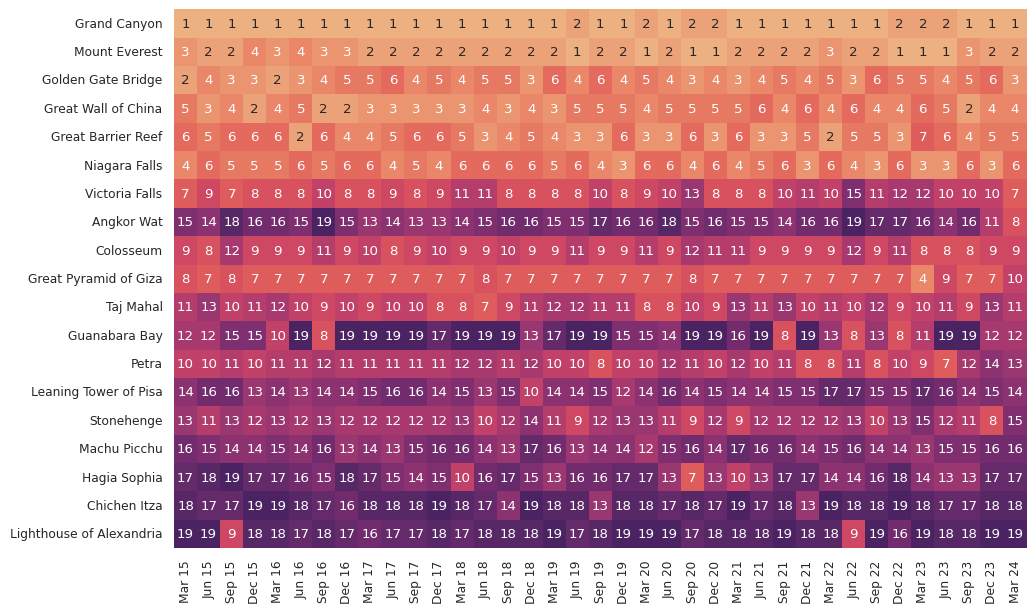

In [59]:
chart_keys, chart_ids = resolve_summary_ids(WONDERS)
chart_summary = summary_ranks[chart_ids]
chart_ranks = np.zeros_like(chart_summary, dtype=np.int64)
np.put_along_axis(chart_ranks,
                  chart_summary.argsort(axis=0),
                  1 + np.repeat(np.arange(chart_summary.shape[0])[:, np.newaxis], time_points, axis=1),
                  0)
chart_summary_order = chart_ranks[:, -1].argsort()
chart_ranks = chart_ranks[chart_summary_order]
chart_keys = np.array(chart_keys)[chart_summary_order].tolist()
fig, ax = plt.subplots(figsize=(11, 7))
ax = sns.heatmap(chart_ranks,
                 xticklabels=[dt.astype(datetime).strftime("%b %y") for dt in date_ser],
                 yticklabels=chart_keys,
                 ax=ax,
                 cmap='flare',
                 cbar=False,
                 annot=True)

In [60]:
id_map["New York (state)"]

1331341

In [61]:
interact(show_chart, query="")

interactive(children=(Text(value='', description='query'), Output()), _dom_classes=('widget-interact',))

<function __main__.show_chart(query)>

In [47]:
pager(PR.with_columns(pl.Series("relevance", relevance)).filter(pl.col("relevance") > 0).sort("relevance", descending=True), 20)

interactive(children=(IntSlider(value=50903, description='page', max=101807), Output()), _dom_classes=('widget…

<function nbhelpers.polars.pager.<locals>.<lambda>(page)>

In [62]:
with open(files.in_degree_filename, "rb") as fp:
    in_degree = np.load(fp)
with open(files.out_degree_filename, "rb") as fp:
    out_degree = np.load(fp)

In [63]:
titles_in_node_order_tbl = pyarrow.table({
    "k": pyarrow.array(id_map.keys(), size=len(id_map)),
    "v": pyarrow.array(id_map.values(), size=len(id_map)),
})

In [64]:
titles_in_node_order = titles_in_node_order_tbl.sort_by("v").columns[0]
titles_in_node_order

[
  [
    "Anarchism",
    "Albedo",
    "A",
    "Alabama",
    "Achilles",
    ...
    "Diving at the 2024 European Aquatics Championships – Women's 3 m springboard",
    "1993 AT&T Challenge – Doubles",
    "Bernstein's Bagels",
    "Rajitha (name)",
    "Tomas Lukminas"
  ]
]

In [65]:
def perplexity(distribution):
    return np.power(2, np.sum(-distribution * np.log2(distribution)))

def personalized_page_rank(preference, threshold=1, random_jump_prob=0.15):
    global files
    global N
    global in_degree
    global out_degree
    current_rank = np.ones(N, dtype=np.float64) / N
    next_rank = np.zeros(N, dtype=np.float64)
    # iteratively update current_rank
    edge_follow_prob = 1 - random_jump_prob
    prev_perplexity = float('inf')
    current_perplexity = perplexity(current_rank)
    current_iter = 0
    iter_start = time.time()
    print("Itr# | ΔPerplexity     | Seconds")
    while abs(prev_perplexity - current_perplexity) > threshold:
        current_iter += 1
        next_rank[:] = random_jump_prob * preference
        # update destinations from non-sink nodes (N x N times N x 1 -> N x 1)
        spread_probs = np.vstack([
            adjacency_matrix_slice.dot(current_rank[:, np.newaxis])
            for adjacency_matrix_slice in map(scipy.sparse.load_npz, files.adjacency_filenames(NUM_PARTITIONS))
        ])
        next_rank += edge_follow_prob * spread_probs[:, 0]  # make column vector 1-D
        # update destinations from sink nodes
        next_rank[:] += edge_follow_prob * current_rank[out_degree == 0].sum() / N
        # copy `next_rank` values into `current_rank``
        current_rank[:] = next_rank
        # --
        # compute perplexity and progress
        prev_perplexity = current_perplexity
        current_perplexity = perplexity(current_rank)
        next_iter_start = time.time()
        print("{:<3d}    {:<15.6f}   {:.3f}".format(current_iter,
                                                    current_perplexity - prev_perplexity,
                                                    next_iter_start - iter_start))
        iter_start = next_iter_start
    df = pl.DataFrame({
        "title": titles_in_node_order, "value": next_rank, "in_deg": in_degree, "out_deg": out_degree,
    })
    return df

In [66]:
relevance /= relevance.sum()

In [67]:
PPR = personalized_page_rank(relevance)

Itr# | ΔPerplexity     | Seconds
1      -6597966.239536   6.088
2      -6938.353567      3.979
3      -31531.267861     3.580
4      -12446.230656     3.458
5      -9754.802308      3.501
6      -5821.328460      3.437
7      -4341.482645      3.402
8      -2919.341035      3.409
9      -2139.248604      3.436
10     -1505.308098      3.454
11     -1100.385170      3.484
12     -790.982323       3.408
13     -581.109725       3.488
14     -422.950753       3.471
15     -312.721442       3.422
16     -229.826876       3.453
17     -170.903640       3.411
18     -126.579135       3.447
19     -94.649130        3.510
20     -70.520565        3.496
21     -52.998840        3.492
22     -39.684659        3.405
23     -29.953177        3.440
24     -22.522419        3.443
25     -17.063807        3.445
26     -12.874952        3.492
27     -9.786785         3.418
28     -7.405922         3.511
29     -5.645579         3.470
30     -4.282792         3.431
31     -3.272952         3.474
32    

In [68]:
PPR.write_parquet(files.redditrank_parquet_filename)

In [69]:
PPR_sorted = PPR.sort("value", descending=True)

In [70]:
pager(PPR_sorted.slice(0, 2000), 20)

interactive(children=(Dropdown(description='page', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

<function nbhelpers.polars.pager.<locals>.<lambda>(page)>

In [71]:
searcher(
    PPR_sorted.slice(0, 1000000).with_row_count(name="rank").select(["rank", *PPR_sorted.columns]),
    ['title'],
    20
)

interactive(children=(Text(value='', description='q'), Output()), _dom_classes=('widget-interact',))

<function nbhelpers.polars.searcher.<locals>.searcher_run(q)>